In [ ]:
# author: Sylwester Arabas
# copyright: Jagiellonian University
# license: CC BY

In [1]:
from numpy import exp, log, empty
from scipy import constants as sci, integrate as ode, optimize as root

In [2]:
import pint
si = pint.UnitRegistry()

In [36]:
import mendeleev as pt
def awgh(x):
    return x.atomic_weight * si.gram / si.mole

In [4]:
# constants
class phys:
    g     = sci.g * si.metre / si.second**2
    pi    = sci.pi
    R_str = sci.R * si.joule / si.kelvin / si.mole       

    rho_w = 1 * si.kilograms / si.litres
    c_pd  = 1005 * si.joule / si.kilogram / si.kelvin
    c_pv  = 1850 * si.joule / si.kilogram / si.kelvin
    c_pw  = 4218 * si.joule / si.kilogram / si.kelvin
    sgm   = 0.072   * si.joule / si.metre**2
    p_tri = 611.73  * si.pascal
    T_tri = 273.16  * si.kelvin
    l_tri = 2.5e6   * si.joule / si.kilogram
    D0    = 2.26e-5 * si.metre**2 / si.second
    K0    = 2.4e-2  * si.joules / si.metres / si.seconds / si.kelvins
    
    Md    = 0.78 * awgh(pt.N) * 2 + 0.21 * awgh(pt.O) * 2 + 0.01 * awgh(pt.Ar)
    Mv    = awgh(pt.O) + awgh(pt.H) * 2
    eps   = Mv / Md
    Rd    = R_str / Md
    Rv    = R_str / Mv

In [5]:
# mass-weighted mixing with specific humidity
phys.mix = lambda q, dry, vap: vap * q + dry * (1 - q)
phys.c_p = lambda q: phys.mix(q, phys.c_pd, phys.c_pv)
phys.R   = lambda q: phys.mix(q, phys.Rd, phys.Rv)

# latent heat of evaporation 
phys.lv  = lambda T: phys.l_tri + (phys.c_pv - phys.c_pw) * (T - phys.T_tri)

# integrated Clausius-Clapeyron eq.
phys.pvs = lambda T: phys.p_tri * exp(
    (phys.l_tri + (phys.c_pw - phys.c_pv) * phys.T_tri) / phys.Rv * (1 / phys.T_tri - 1/T) - 
    (phys.c_pw - phys.c_pv) / phys.Rv * log(T / phys.T_tri)
)

# pressure deriv. (hydrostatic) 
phys.dp_dt = lambda p, q, T, w: -(p / phys.R(q) / T) * phys.g * w

# specific humidity deriv. (monodisperse)
phys.dq_dt = lambda q, N, r, dr_dt: (q-1) * 4 * phys.pi * phys.rho_w * N * 3 * r**2 * dr_dt

# temperature deriv. (adiabatic)
phys.dT_dt = lambda T, q, p, dp_dt, dq_dt: (T * phys.R(q) / p * dp_dt - phys.lv(T) * dq_dt) / phys.c_p(q)

# RH from specific humidity, temperature and pressure
phys.RH = lambda T, p, q: p * q / (phys.eps + q * (1 - phys.eps)) / phys.pvs(T)

# Maxwel-Mason coefficients
phys.Fd = lambda T: phys.rho_w * phys.Rv * T / phys.D0 / phys.pvs(T)
phys.Fk = lambda T, lv: phys.rho_w * lv / phys.K0 / T * (lv / phys.Rv / T - 1)

# Koehler curve (expressed in partial pressure)
phys.khlr_A = lambda T: 2 * phys.sgm / phys.Rv / T / phys.rho_w
phys.khlr_B = lambda kp, rd: kp * rd**3

# radius derivative (Maxwel-Mason eq.)
phys.dr_dt = lambda T, r, p, q, kp, rd: 1 / r / (phys.Fk(T, phys.lv(T)) + phys.Fd(T)) * (
    phys.RH(T, p, q) - 1 
    - phys.khlr_A(T)/r
    + phys.khlr_B(kp, rd)/r**3
)

In [6]:
# state vector indices and units
class ix:
    r, r_unit = 0, si.metre
    q, q_unit = 1, si.dimensionless
    p, p_unit = 2, si.pascal
    T, T_unit = 3, si.kelvin
    t_unit = si.second
    n = 4

In [11]:
def magn(unit, quan):
    return quan.to(unit).magnitude

In [12]:
# parcel model with monodisperse aerosol/droplet population
class dy_dt:   
    def __call__(self, t, y):
        for fld in ("w", "kp", "N", "rd"): 
            assert hasattr(self, fld), f"please set {fld} with dy_dt.{fld} = ..."

        t = t * ix.t_unit
        r = y[ix.r] * ix.r_unit
        q = y[ix.q] * ix.q_unit
        p = y[ix.p] * ix.p_unit
        T = y[ix.T] * ix.T_unit

        dp_dt = phys.dp_dt(p, q, T, self.w(t))
        dr_dt = phys.dr_dt(T, r, p, q, self.kp, self.rd)
        dq_dt = phys.dq_dt(q, self.N, r, dr_dt)
        dT_dt = phys.dT_dt(T, q, p, dp_dt, dq_dt)
        
        dy_dt = empty(ix.n)
        dy_dt[ix.p] = magn(ix.p_unit/ix.t_unit, dp_dt)
        dy_dt[ix.r] = magn(ix.r_unit/ix.t_unit, dr_dt)
        dy_dt[ix.q] = magn(ix.q_unit/ix.t_unit, dq_dt)
        dy_dt[ix.T] = magn(ix.T_unit/ix.t_unit, dT_dt)

        return dy_dt

In [29]:
def main(*, t, dt_max, T0, p0, q0, w, N, rd, kp):
    sys = dy_dt()
    sys.w = w
    sys.N = N
    sys.kp = kp
    sys.rd = rd

    r0 = root.brentq(
        lambda x: magn(ix.r_unit / ix.t_unit, phys.dr_dt(T0, x * ix.r_unit, p0, q0, kp, rd)) + x, 
        magn(ix.r_unit, 2*sys.rd),
        magn(ix.r_unit, 4*sys.rd) # TODO: we can do better!
    ) * ix.r_unit
    
    y0 = empty(ix.n)
    y0[ix.q] = magn(ix.q_unit, q0)
    y0[ix.p] = magn(ix.p_unit, p0)
    y0[ix.T] = magn(ix.T_unit, T0)
    y0[ix.r] = magn(ix.r_unit, r0)
        
    integ = ode.solve_ivp(sys, [0,t / ix.t_unit], y0, method='BDF', max_step=magn(ix.t_unit, dt_max))
    assert integ.success, integ.message
    
    return integ

In [34]:
integ = main(
    t = 40 * si.seconds,
    dt_max = .05 * si.seconds,
    T0 = 300 * si.kelvin,
    p0 = 1000 * si.hectopascals,
    q0 = 21 * si.grams / si.kilogram,
    w = lambda t: 10 * si.metre / si.second,
    N = 100e6 / si.kilogram,
    rd = .01 * si.micrometre,
    kp = 1.28
)

<IPython.core.display.Javascript object>


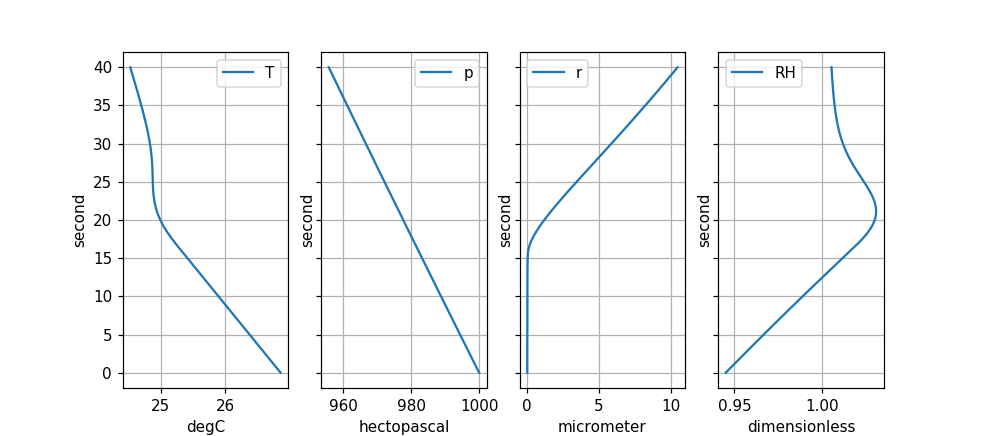

In [40]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

T = integ.y[ix.T] * ix.T_unit
r = integ.y[ix.r] * ix.r_unit
p = integ.y[ix.p] * ix.p_unit
q = integ.y[ix.q] * ix.q_unit
t = integ.t * ix.t_unit

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(9,4))

ax1.plot(T, t, label="T")
ax1.grid()
ax1.legend()
ax1.xaxis.set_units(si.celsius)

ax2.plot(p, t, label="p")
ax2.grid()
ax2.legend()
ax2.xaxis.set_units(si.hectopascals)

ax3.plot(r, t, label="r")
ax3.grid()
ax3.legend()
ax3.xaxis.set_units(si.micrometres)

ax4.plot(phys.RH(T, p, q), t, label="RH")
ax4.grid()
ax4.legend()

plt.show()